In [3]:
def format_trend_chart():
    ax = plt.gca()
    # grids
    ax.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
    ax.xaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)

    # y axis ticks
    ax.set_yticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_yticks()])

    # legend
    ax.legend(loc="lower left", bbox_to_anchor=(1,0))

    # x axis
    plt.gcf().autofmt_xdate() 
    
    return ax

In [420]:
def plot_rev_growth_bubble(df):
    data = np.array(['Service Provider','Previous','Latest','Growth','Increase'])
    for sp, sp_df in df.groupby('Service Provider'):
        prev = 0
        last = 0
        for up, up_df in sp_df.groupby('Usage Period'):
            if(up.date() in PREV_QUARTER):
                prev = prev + up_df['Value (USD)'].sum()
            elif (up.date() in LAST_QUARTER):
                last = last + up_df['Value (USD)'].sum()

        if((prev > 0) and (last-prev > MIN_INCREASE)):
            if(last/prev > MIN_GROWTH):
                print("{:48s}| ${:6,.0f} > ${:8,.0f} (+{:8,.0f}%)".format(sp,prev,last,(last/prev-1)*100))
            data = np.vstack([data,[sp,prev,last,last/prev-1,last-prev]])

    plt.scatter(data[1:,4],data[1:,3],s=data[1:,2].astype(np.float)/BUBBLE_SIZE_DENOM,alpha=0.6)

    ax = plt.gca()
    for cols in data[1:,:]:
        ax.annotate(cols[0],
                    xy=(cols[4],cols[3]), 
                    xytext=(cols[4],cols[3]))

    ax.xaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
    ax.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)

    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.set_xlabel('YoY QRR Increase')

    ax.set_yticklabels(['+{:.0f}%'.format(y*100) for y in ax.get_yticks()])
    ax.set_ylabel('YoY QRR Growth')
    plt.gcf().set_size_inches(10,6)
    plt.show()

In [128]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

df_raw = pd.read_csv("GlobalUsageReport.csv",encoding="ISO-8859-1",parse_dates=['Usage Period'])
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124447 entries, 0 to 124446
Data columns (total 41 columns):
Aggregator               124447 non-null object
Aggregator Partner ID    124447 non-null int64
Service Provider         124447 non-null object
SP Partner ID            124447 non-null int64
Contract No              124447 non-null int64
Contract Size            124447 non-null float64
Collected Point          124447 non-null float64
Base Price               124447 non-null float64
Overage Price            124447 non-null float64
Currency                 124447 non-null object
GEO                      124447 non-null object
Country                  124447 non-null object
Country Code             124363 non-null object
State                    80513 non-null object
City                     124429 non-null object
Postcode                 124337 non-null object
Product Family           124447 non-null object
Product                  124005 non-null object
SKU                      

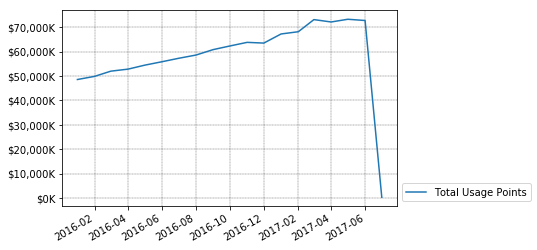

In [129]:
plt.close()
g = df_raw.groupby('Usage Period')['Usage Points'].sum()

plt.plot(g.index,g.values,label='Total Usage Points')
format_trend_chart()
plt.show()

LAST_QUARTER = [datetime.date(2017,2,1),
                datetime.date(2017,3,1),
                datetime.date(2017,4,1)]

PREV_QUARTER = [datetime.date(2016,2,1),
                datetime.date(2016,3,1),
                datetime.date(2016,4,1)]

df = df_raw[(df_raw['Usage Period']<=LAST_QUARTER[2]) & (df_raw['Usage Period']>=PREV_QUARTER[0])]

In [428]:
df_last[df_last['Service Provider'] == 'Dimension Data'].groupby('Country')['Value (USD)'].sum().sort_values()


Country
United States         0.00
Brazil             2234.40
Poland             4107.87
Luxembourg        13377.63
Indonesia         22477.28
Hong Kong         22751.68
Japan             47732.53
New Zealand       97781.50
South Africa     119399.63
Netherlands      177236.73
Australia        292791.04
Name: Value (USD), dtype: float64

YoY Partner Count Growth: +4%
YoY Revenue Growth: +33%


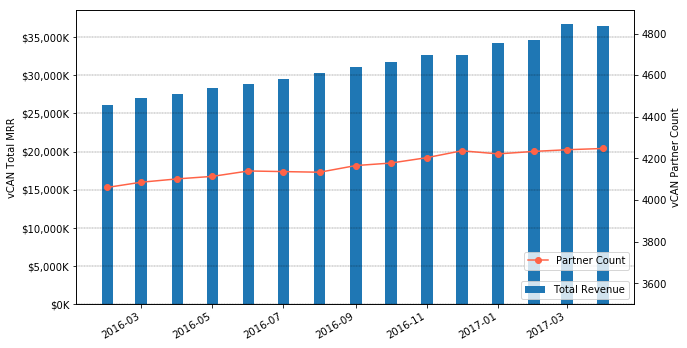

In [130]:

plt.close()
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

rev = df.groupby('Usage Period')['Value (USD)'].sum()
ax1.bar(rev.index,rev.values,10,label='Total Revenue')

cnt = df.groupby('Usage Period')['Service Provider'].unique()
pcnts = list(map(lambda x: len(x), cnt.values))
ax2.plot(cnt.index,list(map(lambda x: len(x), cnt.values)),'o-',c='tomato',label='Partner Count')
ax2.set_ylim(bottom=3500,top=3500*rev.values.max()/rev.values.min())
ax2.set_ylabel('vCAN Partner Count')
ax2.legend(loc="lower right", bbox_to_anchor=(1,0.1))

x0=len(cnt.loc[PREV_QUARTER[2]])
x1=len(cnt.loc[LAST_QUARTER[2]])

an_x = LAST_QUARTER[2]
an_y = x1

an_x_box = PREV_QUARTER[2]
an_y_box = x0

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
arrow_props=dict(facecolor='gray',shrink=0.01,alpha=0.2)

#ax2.annotate("YoY Growth: +{:.0f}%".format((x1/x0-1)*100),
#             xy=(an_x,an_y), 
#             xytext=(an_x_box, an_y_box),
#             bbox=bbox_props,arrowprops=arrow_props,
#             horizontalalignment='right',
#             verticalalignment='bottom'
#            )
print("YoY Partner Count Growth: +{:.0f}%".format((x1/x0-1)*100))

from functools import reduce

x0=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],PREV_QUARTER))
x1=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],LAST_QUARTER))

an_x = LAST_QUARTER[2]
an_y = x1

an_x_box = PREV_QUARTER[2]
an_y_box = x0

#ax1.annotate("YoY Growth: +{:.0f}%".format((x1/x0-1)*100),
#             xy=(an_x,an_y), 
#             xytext=(an_x_box, an_y_box),
#             bbox=bbox_props,
#             arrowprops=arrow_props,
#             horizontalalignment='right',
#             verticalalignment='bottom'
#            )
print("YoY Revenue Growth: +{:.0f}%".format((x1/x0-1)*100))

ax1.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
ax1.set_yticklabels(['${:,.0f}K'.format(x/1000) for x in ax1.get_yticks()])
ax1.set_ylabel('vCAN Total MRR')
ax1.legend(loc="lower right", bbox_to_anchor=(1,0))

fig = plt.gcf()
fig.autofmt_xdate() 
#plt.title("vCAN Business Trend")
fig.set_size_inches(10,6)
plt.show()


In [403]:
df_last = df[(df['Usage Period'] >= LAST_QUARTER[0]) & (df['Usage Period'] <= LAST_QUARTER[2])]
df_prev = df[(df['Usage Period'] >= PREV_QUARTER[0]) & (df['Usage Period'] <= PREV_QUARTER[2])]
s_last = df_last.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
s_prev = df_prev.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

COUNTRY2GEO = {
'Algeria': 'EMEA',
'Argentina': 'AMER',
'Armenia': 'EMEA',
'Australia': 'APAC',
'Austria': 'EMEA',
'Bahamas': 'AMER',
'Bangladesh': 'APAC',
'Belarus': 'EMEA',
'Belgium': 'EMEA',
'Bermuda': 'AMER',
'Bolivia': 'AMER',
'Bosnia and Herzegovina': 'EMEA',
'Brazil': 'AMER',
'Bulgaria': 'EMEA',
'Canada': 'AMER',
'Cayman Islands': 'AMER',
'Chile': 'AMER',
'China': 'APAC',
'Colombia': 'AMER',
'Costa Rica': 'AMER',
'Croatia': 'EMEA',
'CuraÃ§ao': 'AMER',
'Cyprus': 'EMEA',
'Czech Republic': 'EMEA',
'Denmark': 'EMEA',
'Dominican Republic': 'AMER',
'Ecuador': 'AMER',
'Egypt': 'EMEA',
'Estonia': 'EMEA',
'Faeroe Islands': 'EMEA',
'Fiji': 'APAC',
'Finland': 'EMEA',
'France': 'EMEA',
'Germany': 'EMEA',
'Ghana': 'EMEA',
'Greece': 'EMEA',
'Greenland': 'EMEA',
'Guadeloupe': 'EMEA',
'Guam': 'AMER',
'Guatemala': 'AMER',
'Guernsey': 'EMEA',
'Hong Kong': 'APAC',
'Hungary': 'EMEA',
'Iceland': 'EMEA',
'India': 'APAC',
'Indonesia': 'APAC',
'Ireland': 'EMEA',
'Isle of Man': 'EMEA',
'Israel': 'EMEA',
'Italy': 'EMEA',
'Jamaica': 'AMER',
'Japan': 'APAC',
'Jersey': 'EMEA',
'Jordan': 'EMEA',
'Kazakhstan': 'EMEA',
'Kenya': 'EMEA',
'Korea': 'APAC',
'Kuwait': 'EMEA',
'Latvia': 'EMEA',
'Lebanon': 'EMEA',
'Liechtenstein': 'EMEA',
'Lithuania': 'EMEA',
'Luxembourg': 'EMEA',
'Macao': 'APAC',
'Macedonia': 'EMEA',
'Madagascar': 'EMEA',
'Malaysia': 'APAC',
'Malta': 'EMEA',
'Martinique': 'EMEA',
'Mauritius': 'EMEA',
'Mexico': 'AMER',
'Monaco': 'EMEA',
'Morocco': 'EMEA',
'Myanmar': 'APAC',
'Namibia': 'EMEA',
'Netherlands': 'EMEA',
'New Caledonia': 'EMEA',
'New Zealand': 'APAC',
'Nigeria': 'EMEA',
'Norway': 'EMEA',
'Oman': 'EMEA',
'Panama': 'AMER',
'Papua New Guinea': 'APAC',
'Peru': 'AMER',
'Philippines': 'APAC',
'Poland': 'EMEA',
'Portugal': 'EMEA',
'Puerto Rico': 'AMER',
'Qatar': 'EMEA',
'Romania': 'EMEA',
'Russian Federation': 'EMEA',
'RÃ©union': 'EMEA',
'Saudi Arabia': 'EMEA',
'Serbia': 'EMEA',
'Singapore': 'APAC',
'Slovakia': 'EMEA',
'Slovenia': 'EMEA',
'South Africa': 'EMEA',
'Spain': 'EMEA',
'Sri Lanka': 'APAC',
'Sweden': 'EMEA',
'Switzerland': 'EMEA',
'Taiwan': 'APAC',
'Thailand': 'APAC',
'Trinidad and tobago': 'AMER',
'Turkey': 'EMEA',
'Ukraine': 'EMEA',
'United Arab Emirates': 'EMEA',
'United Kingdom': 'EMEA',
'United States': 'AMER',
'Uruguay': 'AMER',
'VietNam': 'APAC'
}
#print('{')
#for c,c_df in df_last.groupby('Country'):
#    print("'{}': '{}',".format(c,'-'.join(set(c_df['GEO'].values))))


Rackspace US, Inc                United States (AMER) $   742,220 (30%)
SAVVIS                           United States (AMER) $ 1,558,705 (167%)
OVH                              France       (EMEA) $   394,496 (30%)
IBM                              United States (AMER) $ 1,111,711 (479%)
Internet Initiative Japan Inc.   Japan        (APAC) $   369,359 (41%)
NTT DATA Inc.                    United States (AMER) $   775,196 (444%)
Softlayer Technologies, Inc.     United States (AMER) $   686,731 (436%)
Virtustream                      United States (AMER) $   469,045 (146%)
SoftLayer                        United Kingdom (EMEA) $   659,798 (1079%)
Hewlett-Packard Enterprise Company United Kingdom (EMEA) $   340,263 (97%)
Revera Ltd                       New Zealand  (APAC) $   301,011 (80%)
Telefonica Soluciones de InformÃ¡tica y Comunicaciones de EspaÃ±a, S.A.U. Spain        (EMEA) $   343,201 (368%)


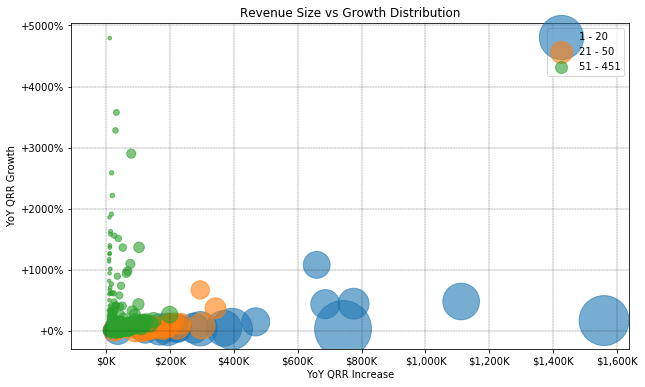

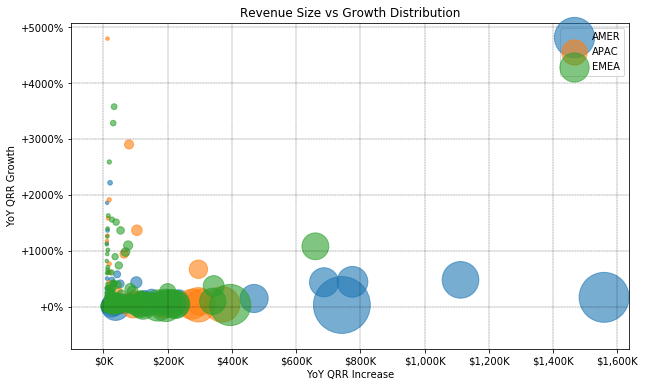

Internet Initiative Japan Inc.   Japan        $   369,359 (41%)
NTT Communications Corporation   Japan        $   295,384 (33%)
Telstra                          Australia    $   275,751 (44%)
IDC Frontier Inc.                Japan        $   186,739 (35%)
Revera Ltd                       New Zealand  $   301,011 (80%)
Datacom Systems Ltd              New Zealand  $   142,854 (53%)
Computer Concepts Limited        New Zealand  $   295,573 (669%)
SoftBank Corp.                   Japan        $   112,225 (65%)
NS Solutions Corporation         Japan        $   106,887 (151%)
FreeBit Co.,Ltd.                 Japan        $   104,067 (1367%)


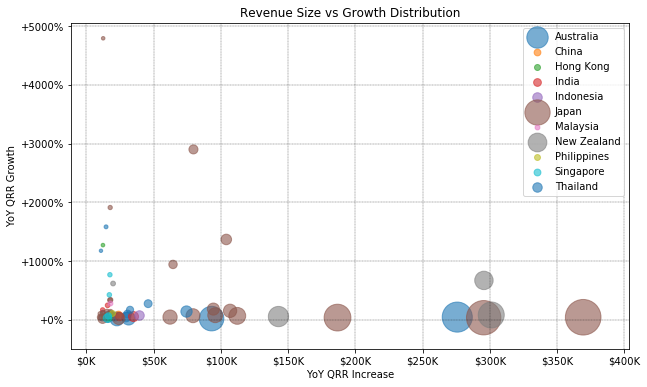

In [429]:
def format_plot():
    ax = plt.gca()
#for cols in data[1:,:]:
#    ax.annotate(cols[0],
#                xy=(cols[4],cols[3]), 
#                xytext=(cols[4],cols[3]))

# Grid
    ax.xaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
    ax.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
# Axis Label
    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.set_xlabel('YoY QRR Increase')
    ax.set_yticklabels(['+{:.0f}%'.format(y*100) for y in ax.get_yticks()])
    ax.set_ylabel('YoY QRR Growth')
# Legend
    ax.legend(loc="upper right")
    
    plt.gcf().set_size_inches(10,6)
    plt.title('Revenue Size vs Growth Distribution')

df_last = df[(df['Usage Period'] >= LAST_QUARTER[0]) & (df['Usage Period'] <= LAST_QUARTER[2])]
df_prev = df[(df['Usage Period'] >= PREV_QUARTER[0]) & (df['Usage Period'] <= PREV_QUARTER[2])]
s_last = df_last.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
s_prev = df_prev.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

data = np.array(['Service Provider','Previous','Latest','Growth','Increse','GEO','Country'])

for sp in s_last.index:
    if sp in s_prev.index:
        prev = s_prev.loc[sp]
        last = s_last.loc[sp]
        if prev > 0 and (last-prev)>10000 and last/prev < 50:
            df_sp = df_last[df_last['Service Provider']==sp]
            country = df_sp['Country'].values[0]
            geo = COUNTRY2GEO[country]
            growth = last/prev-1
            data = np.vstack([data,[sp,prev,last,growth,last-prev,geo,country]])
            if last-prev >300000:
                print('{:32} {:12} ({}) ${:10,.0f} ({:.0f}%)'.format(sp,country,geo,last-prev,growth*100))
                
plt.close()
ranges=[[1,20],[21,50],[51,data.shape[0]-1]]
for r in ranges:
    plt.scatter(data[r[0]:r[1],4],data[r[0]:r[1],3],s=data[r[0]:r[1],2].astype(np.float)/BUBBLE_SIZE_DENOM,alpha=0.6,label='{} - {}'.format(r[0],r[1]))

format_plot()
plt.show()

geos=['AMER','APAC','EMEA']

for geo in geos:
    geo_data = data[data[:,5]==geo]
    plt.scatter(geo_data[:,4],geo_data[:,3],s=geo_data[:,2].astype(np.float)/BUBBLE_SIZE_DENOM,alpha=0.6,label=geo)

format_plot()
plt.show()

apac_data = data[data[:,5]=='APAC']
for d in apac_data:
    growth_val = float(d[4])
    growth = float(d[3])
    if growth_val > 100000:
        print('{:32} {:12} ${:10,.0f} ({:.0f}%)'.format(d[0],d[6],growth_val,growth*100))

for c in sorted(set(apac_data[:,6])):
    c_data = apac_data[apac_data[:,6]==c]
    plt.scatter(c_data[:,4],c_data[:,3],s=c_data[:,2].astype(np.float)/BUBBLE_SIZE_DENOM,alpha=0.6,label=c)
format_plot()
plt.show()


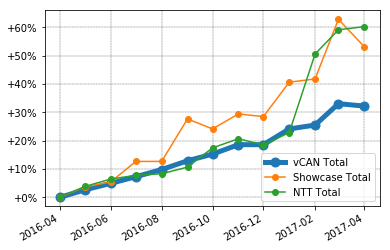

In [146]:
_df = df[df['Usage Period'] >= PREV_QUARTER[2]]

total_rev = _df.groupby('Usage Period')['Value (USD)'].sum()
showcase_rev = _df[_df['Partner Status']=='Showcase'].groupby('Usage Period')['Value (USD)'].sum()
ntt_rev = _df[_df['Partner Group Name']=='NTT'].groupby('Usage Period')['Value (USD)'].sum()
fujitsu_rev = _df[_df['Partner Group Name']=='Fujitsu'].groupby('Usage Period')['Value (USD)'].sum()

plt.close()
plt.plot(total_rev.index,(total_rev.values/total_rev.values[0]-1)*100,'o-',label='vCAN Total',linewidth=5.0,markersize=9.0)
plt.plot(showcase_rev.index,(showcase_rev.values/showcase_rev.values[0]-1)*100,'o-',label='Showcase Total')
plt.plot(ntt_rev.index,(ntt_rev.values/ntt_rev.values[0]-1)*100,'o-',label='NTT Total')
#plt.plot(fujitsu_rev.index,(fujitsu_rev.values/fujitsu_rev.values[0]-1)*100,'o-',label='Fujitsu Total')
ax = format_trend_chart()
ax.set_yticklabels(['+{:,.0f}%'.format(x) for x in ax.get_yticks()])
#plt.gcf().set_size_inches(10,6)
ax.legend(loc="lower right", bbox_to_anchor=(1,0))
plt.show()



Dimension Data                                  | $577,178 > $ 799,890 (+      39%)
NTT Australia Pty Ptd                           | $42,212 > $  61,687 (+      46%)
NTT Communications Corporation                  | $888,461 > $1,183,845 (+      33%)
NTT DATA Inc.                                   | $174,504 > $ 949,701 (+     444%)
NTT Europe Ltd                                  | $211,372 > $ 323,919 (+      53%)
NTT Singapore Pte Ltd                           | $59,293 > $  75,055 (+      27%)


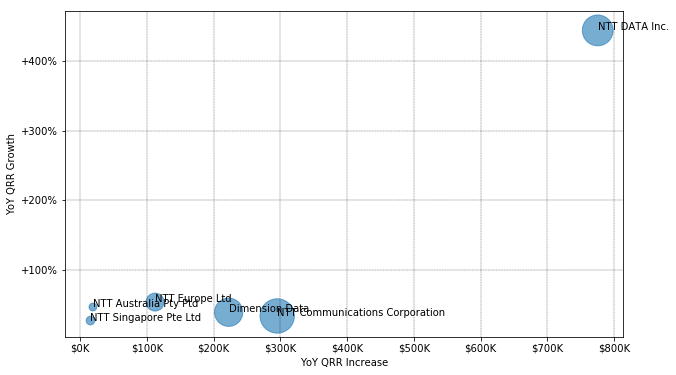

In [421]:
MIN_INCREASE = 10000
MIN_GROWTH = 0
BUBBLE_SIZE_DENOM = 1000

plot_rev_growth_bubble(df[df['Partner Group Name']=='NTT'])


FUJITSU FIP CORPORATION                         | $ 6,849 > $  71,317 (+     941%)
Fujitsu America Inc                             | $194,561 > $ 279,738 (+      44%)
Fujitsu Australia Limited                       | $512,099 > $ 605,229 (+      18%)
Fujitsu Limited (Japan)                         | $126,360 > $ 222,189 (+      76%)
Fujitsu Technology Solutions GmbH               | $484,926 > $ 601,109 (+      24%)


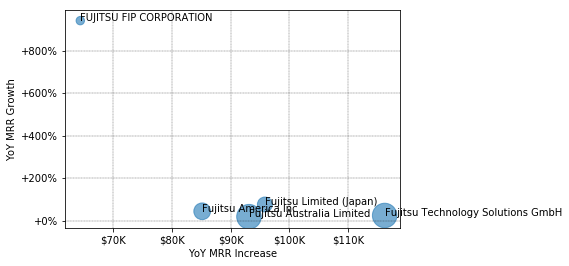

In [79]:
MIN_INCREASE = 10000
MIN_GROWTH = 0
BUBBLE_SIZE_DENOM = 1000

plot_rev_growth_bubble(df[df['Partner Group Name']=='Fujitsu'])


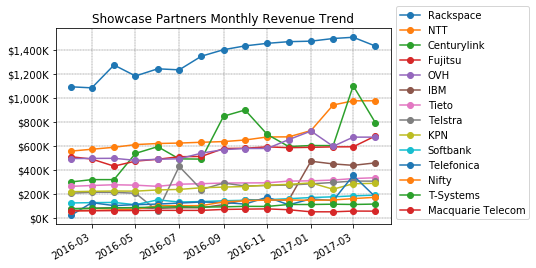

In [134]:
showcase_partners = df[(df['Usage Period'] == LAST_QUARTER[2]) &
                       (df['Partner Status'] == 'Showcase')].groupby('Partner Group Name')['Value (USD)'].sum().sort_values(ascending=False).index

for partner in showcase_partners:
    partner_rev = df[df['Partner Group Name'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    plt.plot(partner_rev.index,partner_rev.values,'o-',label=partner)

format_trend_chart()

plt.title("Showcase Partners Monthly Revenue Trend")
plt.show()

In [139]:
for i in df[df['Partner Group Name']=="Dimension Data"].index:
    df.set_value(i,'Service Provider','Dimension Data')
    df.set_value(i,'Partner Group Name','NTT')



In [138]:
df[(df['Partner Group Name']=='Dimension Data') & (df['Usage Period'] == LAST_QUARTER[2])]['Value (USD)'].sum()

283096.59

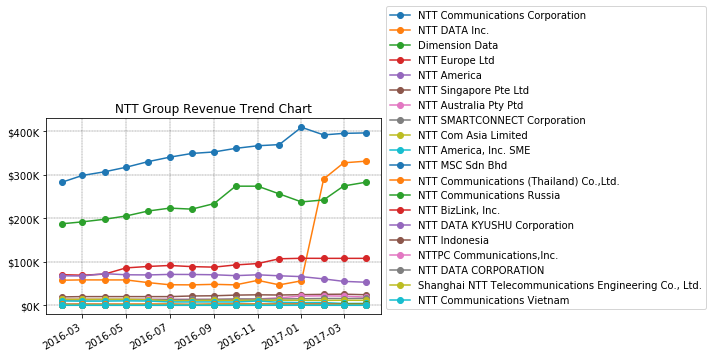

In [144]:
ntt_group = df[(df['Usage Period'] == LAST_QUARTER[2]) &
               (df['Partner Group Name'] == 'NTT')].groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False).index

up_index = sorted(list(set(df['Usage Period'])))

for partner in ntt_group:
    partner_rev = df[df['Service Provider'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    
    # populate 0s for all months to capture no-report months
    for i in up_index:
        if not i in partner_rev.keys():
            partner_rev.set_value(up,0.0)
    data = partner_rev.sort_index()
    
    plt.plot(data.index,data.values,'o-',label=partner)

format_trend_chart()

plt.title('NTT Group Revenue Trend Chart')
plt.show()

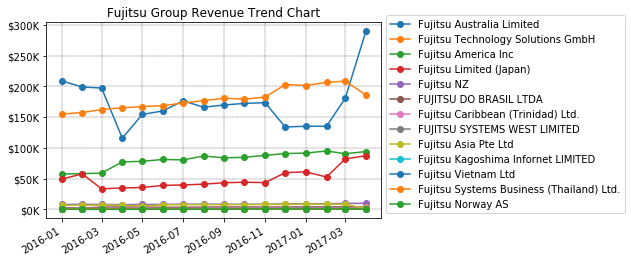

In [102]:
fujitsu_group = df[(df['Usage Period'] == LAST_QUARTER[2]) &
               (df['Partner Group Name'] == 'Fujitsu')].groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False).index

up_index = sorted(list(set(df['Usage Period'])))

plt.close()
for partner in fujitsu_group:
    partner_rev = df[df['Service Provider'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    
    # populate 0s for all months to capture no-report months
    for i in up_index:
        if not i in partner_rev.keys():
            partner_rev.set_value(up,0.0)
    data = partner_rev.sort_index()
    
    plt.plot(data.index,data.values,'o-',label=partner)

    
#fujitsu_total = df[df['Partner Group Name'] == 'Fujitsu'].groupby('Usage Period')['Value (USD)'].sum()
#plt.plot(fujitsu_total.index,fujitsu_total.values,'o-',label='Fujitsu Total')

format_trend_chart()

plt.title('Fujitsu Group Revenue Trend Chart')
plt.show()

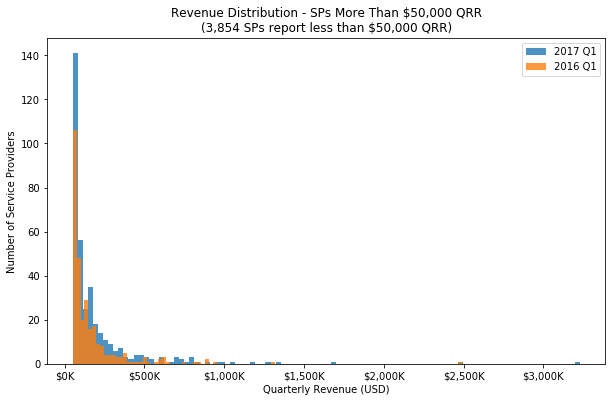

In [201]:
df_last_q = df[(df['Usage Period'] >= LAST_QUARTER[0]) & (df['Usage Period'] <= LAST_QUARTER[2])]
df_prev_q = df[(df['Usage Period'] >= PREV_QUARTER[0]) & (df['Usage Period'] <= PREV_QUARTER[2])]
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum()
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum()

CUTOFF_QRR = 50000
#plt.subplot(121)
plt.hist(data_last[data_last >= CUTOFF_QRR],bins=100,alpha=.8,label='2017 Q1')
plt.hist(data_prev[data_prev >= CUTOFF_QRR],bins=100,alpha=.8,label='2016 Q1')

plt.xlabel("Quarterly Revenue (USD)")
plt.ylabel("Number of Service Providers")
subtitle = "({:,} SPs report less than ${:,} QRR)".format(len(data[data < CUTOFF_QRR]),CUTOFF_QRR)
plt.title("Revenue Distribution - SPs More Than ${:,} QRR\n{}".format(CUTOFF_QRR,subtitle))
ax = plt.gca()
fig = plt.gcf()
ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
ax.legend(loc="upper right")
fig.set_size_inches(10,6)
plt.show()



Service Provider
Rackspace US, Inc                 0.030002
SAVVIS                            0.023162
OVH                               0.015786
IBM                               0.012482
Internet Initiative Japan Inc.    0.011777
NTT Communications Corporation    0.010997
Rackspace Ltd                     0.009725
Tieto Corporation                 0.009059
NTT DATA Inc.                     0.008822
Telstra                           0.008411
Name: Value (USD), dtype: float64
----------------------------------------------



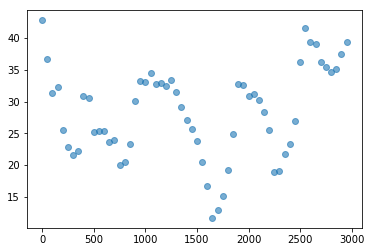

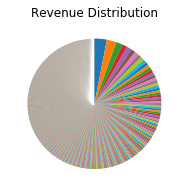

In [341]:
df_last_q = df[(df['Usage Period'] >= LAST_QUARTER[0]) & (df['Usage Period'] <= LAST_QUARTER[2])]
df_prev_q = df[(df['Usage Period'] >= PREV_QUARTER[0]) & (df['Usage Period'] <= PREV_QUARTER[2])]
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

total_prev = df_prev_q['Value (USD)'].sum()
total_last = df_last_q['Value (USD)'].sum()
top10_rev_prev = data_prev[:10].values.sum()

print(data_last[:10]/total_last)

print('----------------------------------------------')
#print("{} ~ {}".format(PREV_QUARTER[0],PREV_QUARTER[2]))
step = 50
#for base in range(0,len(data_prev),step):
#    print("{:4.0f} - {:4.0f} : {:2.2f}%".format(base,base+step,data_prev[base:base+step].values.sum()/total_prev*100))
#print('')
#print("{} ~ {}".format(LAST_QUARTER[0],LAST_QUARTER[2]))

growth_dist = np.empty((0,2), float)
for base in range(0,3000,step):
    _prev = data_prev[base:base+step].values.sum()
    _last = data_last[base:base+step].values.sum()
    growth = (_last/_prev-1)*100
    growth_dist = np.vstack((growth_dist, np.array([base,growth])))
#    print("{:4.0f} - {:4.0f} : {:2.2f} (+{:2.0f}%)".format(base,base+step,_last/total_last*100,growth))
print('')
plt.plot(growth_dist[:,0],growth_dist[:,1],'o',alpha=.6)
plt.show()



plt.pie(data_last.values,startangle=90,counterclock=False)
plt.title('Revenue Distribution')
plt.gcf().set_size_inches(3,3)
plt.show()